In [1]:
import tensorflow

In [21]:
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self, inputs=[]):
        """
        if the node is the operator of "ax + b", the inputs will be x node , and the outputs
        of this is its successors.

        and the value is *ax + b*
        """
        self.inputs = inputs  
       
        self.value = None
        self.outputs = []
        self.gradients = {}

        for node in self.inputs:
            node.outputs.append(self)  # build a connection relationship

    def forward(self):
        """Forward propogation

        compute the output value based on input nodes and store the value
        into *self.value*
        """
        raise NotImplemented

    def backward(self):
        """ Back propogation

        compute the gradient of each input node and store the value
        into "self.gredients"
        """
        raise NotImplemented

In [22]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name = name

    def forward(self, value=None):
        if value is not None:
            self.value = value

    def backward(self):
        self.gradients = {}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost

    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [23]:
import numpy as np
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])

    def forward(self):
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value

    def backward(self):
        for node in self.outputs:
            # gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]
            #print("self.w_node.value.T",self.w_node.value.T)
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)


In [24]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node

    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))

    def forward(self):
        self.value = self._sigmoid(self.x_node.value)

    def backward(self):
        y = self.value
        self.partial = y * (1 - y)
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x_node] = grad_cost * self.partial


In [25]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])

    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)

        self.diff = y_true_flatten - y_hat_flatten

        self.value = np.mean(self.diff ** 2)

    def backward(self):
        n = self.y_hat_node.value.shape[0]
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] = (-2 / n) * self.diff

In [26]:
def training_one_batch(topological_sorted_graph):
    # topological_sorted_graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()

    for node in topological_sorted_graph[::-1]:
        node.backward()

In [27]:
#拓扑排序

In [28]:
def topological_sort(data_with_value):
    feed_dict = data_with_value
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [29]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [30]:
from sklearn.datasets import load_boston
data = load_boston()
X_ = data['data']
print(X_[0])

[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00]


In [31]:
y_ = data['target']

In [32]:
print(y_[0])

24.0


In [33]:
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)
print(X_[0])

[-0.41978194  0.28482986 -1.2879095  -0.27259857 -0.14421743  0.41367189
 -0.12001342  0.1402136  -0.98284286 -0.66660821 -1.45900038  0.44105193
 -1.0755623 ]


In [34]:
n_features = X_.shape[1]#列数
n_hidden = 10

#W1_ 为13 * 10的矩阵
W1_, b1_ = np.random.randn(n_features, n_hidden), np.zeros(n_hidden)
#W2为10*1的矩阵
W2_, b2_ = np.random.randn(n_hidden, 1), np.zeros(1)

X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)


In [35]:

input_node_with_value = {  # -> feed_dict 
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    b1: b1_, 
    b2: b2_
}


In [36]:
from sklearn.utils import resample
graph = topological_sort(input_node_with_value)

def run(dictionary):
    return topological_sort(dictionary)


losses = []
epochs = 5000
batch_size = 64
steps_per_epoch = X_.shape[0] // batch_size
for i in range(epochs):
    loss = 0
    for batch in range(steps_per_epoch):
        # indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        # X_batch = X_[indices]
        # y_batch = y_[indices]
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        X.value = X_batch
        y.value = y_batch
        training_one_batch(graph)
        learning_rate = 1e-3
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)#调整参数
        loss += graph[-1].value

    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i + 1, loss / steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 718.835
Epoch: 101, loss = 42.318
Epoch: 201, loss = 26.610
Epoch: 301, loss = 23.965
Epoch: 401, loss = 25.083
Epoch: 501, loss = 16.538
Epoch: 601, loss = 16.394
Epoch: 701, loss = 12.647
Epoch: 801, loss = 13.602
Epoch: 901, loss = 13.913
Epoch: 1001, loss = 15.738
Epoch: 1101, loss = 13.889
Epoch: 1201, loss = 8.003
Epoch: 1301, loss = 11.013
Epoch: 1401, loss = 9.074
Epoch: 1501, loss = 11.791
Epoch: 1601, loss = 10.593
Epoch: 1701, loss = 9.589
Epoch: 1801, loss = 9.134
Epoch: 1901, loss = 10.337
Epoch: 2001, loss = 10.234
Epoch: 2101, loss = 11.103
Epoch: 2201, loss = 9.259
Epoch: 2301, loss = 8.372
Epoch: 2401, loss = 10.204
Epoch: 2501, loss = 9.053
Epoch: 2601, loss = 8.622
Epoch: 2701, loss = 7.956
Epoch: 2801, loss = 7.924
Epoch: 2901, loss = 8.224
Epoch: 3001, loss = 6.803
Epoch: 3101, loss = 7.931
Epoch: 3201, loss = 7.548
Epoch: 3301, loss = 6.077
Epoch: 3401, loss = 6.930
Epoch: 3501, loss = 5.105
Epoch: 3601, loss = 7.839
Epoch: 3701, loss = 7.004
Epoc

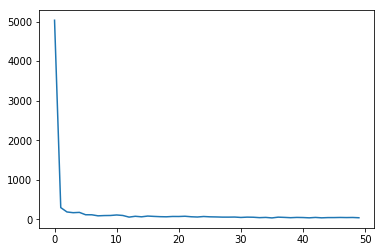

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(losses)

In [41]:
W1.value

array([[-1.29079004,  0.65594486, -0.40278162, -0.5806331 ,  0.63913222,
        -0.28535803,  0.40014719,  0.82468912, -0.64543395, -1.33569852],
       [ 0.02503754, -0.18751752, -0.42949708,  0.26617563,  0.99130608,
         0.23028109,  0.31093634, -0.31105682, -0.02053909, -2.34020414],
       [ 1.5490439 ,  1.23193886,  1.20387802, -0.05349883,  0.93821244,
        -1.081414  ,  2.16046887,  1.53015591, -0.49661639, -3.66360428],
       [ 2.16403988, -0.39897944, -0.2003022 , -1.09758521, -0.52369374,
         0.10966682, -0.7936885 , -0.00688408, -0.03553228,  2.2410664 ],
       [ 1.17277243,  0.39539532, -0.28837541,  0.82153236,  1.39228722,
        -2.50569773, -1.00098069,  0.16930447, -0.79782494, -3.25763032],
       [-0.37899351,  1.84958578,  1.26051948,  1.4467464 ,  1.81426258,
        -0.5002358 ,  0.76466164,  1.4823031 ,  1.66479643, -0.96721322],
       [-0.65907226, -0.32453134, -3.16604637,  0.38762769, -0.92647986,
         0.1050646 , -1.90210033, -0.59500515

In [42]:
W2.value

array([[ 8.14265539],
       [ 6.29309223],
       [ 4.88794707],
       [ 7.29042987],
       [ 3.66354524],
       [ 9.71025139],
       [ 4.81988623],
       [-4.58675777],
       [ 9.40870975],
       [ 4.48524822]])

In [43]:
X_[1]

array([-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
        0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
       -0.30309415,  0.44105193, -0.49243937])

linear_output = Linear(X, W1, b1) 
sigmoid_output = Sigmoid(linear_output) 
yhat = Linear(sigmoid_output, W2, b2) 
loss = MSE(y, yhat)

In [45]:
x1 = Input()

In [46]:
x1.value = X_[1]

In [47]:
y_of_x1 =  Linear(Sigmoid(Linear(x1, W1, b1)), W2, b2)

In [48]:
def _sigmoid(x):
        return 1. / (1 + np.exp(-1 * x))

In [49]:
np.dot(_sigmoid(np.dot(X_[1], W1.value) + b1.value), W2.value) + b2.value

array([22.54080893])

In [50]:
y_[1]

21.6

In [ ]:
按照我们的神经网络预测值是22.54080893，实际值是21.6

In [ ]:
总结神经网络的整个流程：
1.我们一共设置了Input,Linear,Sigmoid,MSE这么几个节点，每个节点的值有指定的计算方法，每个节点有向前向后传播的方法
  前传播计算该节点的值，向后传播计算对应的梯度，用于调整参数
2.准备数据，设置用用到的参数的类型，如W1,W2,b1，b2,实例化每个节点，设置feed_dic
3.把节点进行拓扑排序
4.设置每次训练取样本的数量和训练的总共次数开始训练，每训练一次调整一次参数，让loss越来越小